<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 5: Pretraining on Unlabeled Data
# 第五章：在未标记数据上预训练

In [1]:
# 导入版本检查模块
from importlib.metadata import version

# 定义需要检查版本的包列表
pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # 用于加载OpenAI的预训练权重
       ]

# 遍历包列表并打印每个包的版本号
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.5.0
tensorflow version: 2.18.0


- In this chapter, we implement the training loop and code for basic model evaluation to pretrain an LLM
- At the end of this chapter, we also load openly available pretrained weights from OpenAI into our model
- 在本章中,我们将实现训练循环和基本模型评估代码来预训练一个大语言模型
- 在本章最后,我们还会将OpenAI的开源预训练权重加载到我们的模型中

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp" width=500px>

- The topics covered in this chapter are shown below
- 本章涵盖的主题如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## 5.1 Evaluating generative text models
## 5.1 评估生成式文本模型

- We start this section with a brief recap of initializing a GPT model using the code from the previous chapter
- 我们从简要回顾使用上一章的代码初始化GPT模型开始本节
 - Then, we discuss basic evaluation metrics for LLMs 
- 然后,我们讨论大语言模型的基本评估指标
 - Lastly, in this section, we apply these evaluation metrics to a training and validation dataset
- 最后,在本节中,我们将这些评估指标应用于训练集和验证集

### 5.1.1 Using GPT to generate text
### 5.1.1 使用GPT生成文本

- We initialize a GPT model using the code from the previous chapter
- 我们使用上一章的代码初始化GPT模型

In [2]:
# 导入PyTorch库
import torch
# 从前面章节导入GPT模型
from previous_chapters import GPTModel

# 定义GPT-124M模型的配置参数
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小
    "context_length": 256, # 缩短的上下文长度(原始为1024)
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头数量
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # Dropout比率
    "qkv_bias": False      # 是否使用Query-Key-Value偏置
}

# 设置随机种子以确保可重复性
torch.manual_seed(123)
# 初始化GPT模型
model = GPTModel(GPT_CONFIG_124M)
# 将模型设置为评估模式,禁用dropout
model.eval();  # 在推理过程中禁用dropout

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- 我们在上面使用了0.1的dropout,但现在训练大语言模型通常不使用dropout
- Modern LLMs also don't use bias vectors in the `nn.Linear` layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
- 现代大语言模型在query、key和value矩阵的`nn.Linear`层中也不使用偏置向量(与早期GPT模型不同),这是通过设置`"qkv_bias": False`实现的
- We reduce the context length (`context_length`) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens
- 我们将上下文长度(`context_length`)减少到仅256个token以降低模型训练的计算资源需求,而原始的1.24亿参数的GPT-2模型使用了1024个token
  - This is so that more readers will be able to follow and execute the code examples on their laptop computer
  - 这样更多读者可以在他们的笔记本电脑上运行和执行代码示例
  - However, please feel free to increase the `context_length` to 1024 tokens (this would not require any code changes)
  - 但是,您可以随意将`context_length`增加到1024个token(这不需要任何代码更改)
  - We will also load a model with a 1024 `context_length` later from pretrained weights
  - 稍后我们还将从预训练权重加载一个具有1024 `context_length`的模型

- Next, we use the `generate_text_simple` function from the previous chapter to generate text
- 接下来,我们使用上一章的`generate_text_simple`函数来生成文本
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter
- 此外,我们定义了两个便利函数`text_to_token_ids`和`token_ids_to_text`,用于在本章中进行token和文本表示之间的转换

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=500px>

In [3]:
# 导入tiktoken分词器库
import tiktoken
# 从之前的章节导入文本生成函数
from previous_chapters import generate_text_simple

# 将文本转换为token ID的函数
def text_to_token_ids(text, tokenizer):
    # 使用tokenizer将文本编码为token ID,允许特殊token '<|endoftext|>'
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    # 将编码后的token ID转换为tensor并添加batch维度
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

# 将token ID转换回文本的函数
def token_ids_to_text(token_ids, tokenizer):
    # 移除batch维度
    flat = token_ids.squeeze(0) # remove batch dimension
    # 使用tokenizer将token ID解码为文本
    return tokenizer.decode(flat.tolist())

# 设置初始上下文文本
start_context = "Every effort moves you"
# 初始化GPT-2分词器
tokenizer = tiktoken.get_encoding("gpt2")

# 使用模型生成文本
token_ids = generate_text_simple(
    model=model,  # 使用已定义的模型
    idx=text_to_token_ids(start_context, tokenizer),  # 将初始文本转换为token ID
    max_new_tokens=10,  # 最多生成10个新token
    context_size=GPT_CONFIG_124M["context_length"]  # 使用模型配置中定义的上下文长度
)

# 打印生成的文本结果
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


 - As we can see above, the model does not produce good text because it has not been trained yet
- 如上所示,模型还没有经过训练,所以无法生成好的文本
 - How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- 在训练过程中,我们如何以数字形式衡量或捕捉什么是"好的文本"?
 - The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- 下一小节将介绍用于计算生成输出的损失指标的方法,我们可以用它来衡量训练进度
 - The next chapters on finetuning LLMs will also introduce additional ways to measure model quality
- 后续关于微调LLM的章节还将介绍其他衡量模型质量的方法

<br>

### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity
### 5.1.2 计算文本生成损失:交叉熵和困惑度

 - Suppose we have an `inputs` tensor containing the token IDs for 2 training examples (rows)
- 假设我们有一个包含2个训练样例(行)的token ID的`inputs`张量
 - Corresponding to the `inputs`, the `targets` contain the desired token IDs that we want the model to generate  
- 对应于`inputs`，`targets`包含了我们希望模型生成的目标token ID
 - Notice that the `targets` are the `inputs` shifted by 1 position, as explained in chapter 2 when we implemented the data loader
- 注意`targets`是`inputs`向后移动1个位置得到的,这在第2章实现数据加载器时已经解释过

In [4]:
# 输入张量,包含两个训练样例的token ID序列
# 第一行: "every effort moves"
# 第二行: "I really like" 
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

# 目标张量,是输入向右移动一位得到的序列
# 第一行: " effort moves you" 
# 第二行: " really like chocolate"
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- Feeding the `inputs` to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each
- 将`inputs`输入模型,我们得到2个输入样例的logits向量,每个样例包含3个token
- Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary  
- 每个token都是一个50,257维的向量,对应词汇表的大小
- Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores
- 应用softmax函数,我们可以将logits张量转换为相同维度的概率分数张量

In [5]:
# 使用torch.no_grad()避免计算梯度
with torch.no_grad():
    # 将输入传入模型得到logits
    logits = model(inputs)

# 对logits应用softmax得到每个词汇表中token的概率分布
probas = torch.softmax(logits, dim=-1) # 词汇表中每个token的概率
print(probas.shape) # 形状: (批次大小, token数量, 词汇表大小)

torch.Size([2, 3, 50257])


 - The figure below, using a very small vocabulary for illustration purposes, outlines how we convert the probability scores back into text, which we discussed at the end of the previous chapter
 - 下图使用了一个非常小的词汇表作为示例，概述了如何将概率分数转换回文本，这是我们在上一章末尾讨论过的内容

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- As discussed in the previous chapter, we can apply the `argmax` function to convert the probability scores into predicted token IDs
- 如前一章所述,我们可以使用`argmax`函数将概率分数转换为预测的token ID
- The softmax function above produced a 50,257-dimensional vector for each token; the `argmax` function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token
- 上面的softmax函数为每个token生成了一个50,257维的向量;`argmax`函数返回这个向量中最高概率分数的位置,即给定token的预测token ID

 - Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:
- 由于我们有2个输入批次,每个批次包含3个token,我们得到2×3的预测token ID:

In [6]:
# 使用argmax函数找出每个位置概率最高的token ID
# dim=-1表示在最后一个维度(词汇表维度)上取最大值
# keepdim=True保持输出维度与输入一致
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


 - If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens:
 - 如果我们对这些token进行解码，会发现它们与我们希望模型预测的目标token有很大的不同：

In [7]:
# 打印第一个批次的目标token序列
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
# 打印第一个批次的模型输出token序列
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


 - That's because the model wasn't trained yet
 - 这是因为模型还没有经过训练
 - To train the model, we need to know how far it is away from the correct predictions (targets)
 - 要训练模型，我们需要知道它与正确预测（目标）的差距有多大

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

 - The token probabilities corresponding to the target indices are as follows:
 - 目标索引对应的token概率如下:

In [8]:
# 处理第一个文本序列
text_idx = 0  # 选择第一个批次
# 从probas张量中提取第一个文本序列对应的目标token概率
# probas[text_idx]选择第一个批次
# [0,1,2]选择序列中的3个位置
# targets[text_idx]选择对应的目标token ID
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

# 处理第二个文本序列
text_idx = 1  # 选择第二个批次
# 从probas张量中提取第二个文本序列对应的目标token概率
# 索引方式与上面相同,但是使用第二个批次的数据
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


 - We want to maximize all these values, bringing them close to a probability of 1
 - 我们希望最大化所有这些值，使它们接近于概率1
 - In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself; this is out of the scope of this book, but I have recorded a lecture with more details here: [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)
 - 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易；这超出了本书的范围，但我在这里录制了一个包含更多细节的讲座：[L8.2 逻辑回归损失函数](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [9]:
# 计算所有token概率的对数
# 使用torch.cat连接两个目标概率张量
# 然后使用torch.log计算对数值
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- Next, we compute the average log probability:
- 接下来，我们计算平均对数概率：

In [10]:
# Calculate the average probability for each token
# 计算每个token的平均概率
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- The goal is to make this average log probability as large as possible by optimizing the model weights
- 目标是通过优化模型权重使这个平均对数概率尽可能大

- Due to the log, the largest possible value is 0, and we are currently far away from 0
- 由于对数的特性，最大可能值是0，而我们目前离0还很远

- In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the *negative* average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
- 在深度学习中，与其最大化平均对数概率，标准做法是最小化*负*平均对数概率值；在我们的例子中，与其最大化 -10.7722 使其接近0，在深度学习中，我们会最小化 10.7722 使其接近0
- The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning
- -10.7722的负值，即10.7722，在深度学习中也被称为交叉熵损失

In [11]:
# 计算负平均对数概率
# 将平均对数概率乘以-1得到交叉熵损失
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch already implements a `cross_entropy` function that carries out the previous steps
- PyTorch已经实现了一个`cross_entropy`函数来执行前面的步骤

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=400px>

- Before we apply the `cross_entropy` function, let's check the shape of the logits and targets
- 在应用`cross_entropy`函数之前，让我们检查logits和targets的形状

In [12]:
# logits的形状是(batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# targets的形状是(batch_size, num_tokens) 
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- For the `cross_entropy` function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:
- 对于PyTorch中的`cross_entropy`函数，我们需要通过在batch维度上合并这些张量来将它们展平：

In [13]:
# 将logits张量在第0和第1维度上展平
logits_flat = logits.flatten(0, 1)
# 将targets张量完全展平
targets_flat = targets.flatten()

# 打印展平后的形状
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize
- 请注意，targets是token ID，它们也表示我们想要最大化的logits张量中的索引位置
- The `cross_entropy` function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized
- PyTorch中的`cross_entropy`函数会自动处理在logits中需要最大化的token索引上的softmax和对数概率计算

In [14]:
# 使用PyTorch的交叉熵损失函数计算损失值
# logits_flat: 展平后的logits张量
# targets_flat: 展平后的目标张量
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
# 打印损失值
print(loss)

tensor(10.7940)


- A concept related to the cross-entropy loss is the perplexity of an LLM
- 与交叉熵损失相关的一个概念是LLM的困惑度
- The perplexity is simply the exponential of the cross-entropy loss  
- 困惑度就是交叉熵损失的指数

In [15]:
# 计算困惑度（perplexity）：交叉熵损失的指数
perplexity = torch.exp(loss)
# 打印困惑度值
print(perplexity)

tensor(48725.8203)


- The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)
- 困惑度通常被认为更容易理解，因为它可以被理解为模型在每一步中不确定的有效词汇量大小（在上面的例子中，大约是48,725个单词或标记）

- In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
- 换句话说，困惑度提供了一个衡量标准，用于衡量模型预测的概率分布与数据集中单词的实际分布的匹配程度

- Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
- 与损失类似，较低的困惑度表明模型的预测更接近实际分布

### 5.1.3 Calculating the training and validation set losses
### 5.1.3 计算训练集和验证集的损失

- We use a relatively small dataset for training the LLM (in fact, only one short story)
- 我们使用相对较小的数据集来训练LLM（实际上只有一个短故事）
- The reasons are:
- 原因如下：
  - You can run the code examples in a few minutes on a laptop computer without a suitable GPU
  - 你可以在没有合适GPU的笔记本电脑上在几分钟内运行代码示例
  - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
  - 训练完成相对较快（几分钟而不是几周），这对教育目的来说很好
  - We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size
 - 我们使用来自公共领域的文本，可以将其包含在这个GitHub仓库中而不违反任何使用权或增加仓库大小


- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens
- 例如，Llama 2 7B需要在A100 GPU上使用184,320 GPU小时来训练2万亿个tokens
  - At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately \\$30
  - 在撰写本文时，AWS上8xA100云服务器的每小时成本约为30美元
  - So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * \\$30 =  \\$690,000
  - 因此，通过粗略计算，训练这个LLM的成本将是184,320 / 8 * 30美元 = 690,000美元

- Below, we use the same dataset we used in chapter 2
- 下面，我们使用与第2章相同的数据集

In [16]:
# 导入所需的库
import os
import urllib.request

# 设置文件路径和URL
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# 如果文件不存在,则从URL下载
if not os.path.exists(file_path):
    # 打开URL并读取内容
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    # 将内容写入本地文件
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
# 如果文件已存在,则直接读取
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 100 words
- 通过打印前100个和后100个单词快速检查文本是否正确加载

In [17]:
# 打印前100个字符
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [18]:
# 打印最后100个字符
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [19]:
# 计算文本的总字符数
total_characters = len(text_data)
# 计算文本的总token数
total_tokens = len(tokenizer.encode(text_data))

# 打印统计结果
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)
- 有5,145个tokens的文本对于训练LLM来说非常短,但这只是出于教育目的(我们稍后也会加载预训练权重)

- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- 接下来，我们将数据集分为训练集和验证集，并使用第2章的数据加载器为LLM训练准备批次数据
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- 为了便于可视化，下图假设`max_length=6`，但对于训练加载器，我们将`max_length`设置为等于LLM支持的上下文长度
- The figure below only shows the input tokens for simplicity
- 为了简单起见，下图仅显示输入tokens
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position
    - 由于我们训练LLM来预测文本中的下一个单词，目标看起来与这些输入相同，只是目标位置向后移动了一个位置

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [20]:
# 从前面章节导入数据加载器函数
from previous_chapters import create_dataloader_v1

# 设置训练集和验证集的比例为90:10
train_ratio = 0.90
# 计算分割点索引
split_idx = int(train_ratio * len(text_data))
# 分割训练数据
train_data = text_data[:split_idx]
# 分割验证数据
val_data = text_data[split_idx:]

# 设置随机种子以确保可重复性
torch.manual_seed(123)

# 创建训练数据加载器
train_loader = create_dataloader_v1(
    train_data,                                      # 训练数据
    batch_size=2,                                    # 批次大小为2
    max_length=GPT_CONFIG_124M["context_length"],    # 最大序列长度
    stride=GPT_CONFIG_124M["context_length"],        # 步长等于上下文长度
    drop_last=True,                                  # 丢弃最后不完整的批次
    shuffle=True,                                    # 随机打乱数据
    num_workers=0                                    # 不使用多进程加载
)

# 创建验证数据加载器
val_loader = create_dataloader_v1(
    val_data,                                        # 验证数据
    batch_size=2,                                    # 批次大小为2
    max_length=GPT_CONFIG_124M["context_length"],    # 最大序列长度
    stride=GPT_CONFIG_124M["context_length"],        # 步长等于上下文长度
    drop_last=False,                                 # 保留最后不完整的批次
    shuffle=False,                                   # 不打乱数据
    num_workers=0                                    # 不使用多进程加载
)

In [21]:
# Sanity check
# 检查训练集的token数量是否足够
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

# 检查验证集的token数量是否足够  
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with
- 我们使用相对较小的批量大小来减少计算资源需求，同时也因为数据集本身很小
- Llama 2 7B was trained with a batch size of 1024, for example
- 例如，Llama 2 7B模型训练时使用的批量大小是1024

- An optional check that the data was loaded correctly:
- 一个可选的检查,用于验证数据是否正确加载:

In [22]:
# 打印训练数据加载器中的批次形状
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)  # 打印输入x和目标y的形状

# 打印验证数据加载器中的批次形状 
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)  # 打印输入x和目标y的形状

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Another optional check that the token sizes are in the expected ballpark:
- 另一个可选的检查，用于验证token数量是否在预期范围内：

In [23]:
# 初始化训练集token计数器
train_tokens = 0
# 遍历训练数据加载器中的每个批次
for input_batch, target_batch in train_loader:
    # 累加当前批次中的token数量
    train_tokens += input_batch.numel()

# 初始化验证集token计数器 
val_tokens = 0
# 遍历验证数据加载器中的每个批次
for input_batch, target_batch in val_loader:
    # 累加当前批次中的token数量
    val_tokens += input_batch.numel()

# 打印训练集的token总数
print("Training tokens:", train_tokens)
# 打印验证集的token总数
print("Validation tokens:", val_tokens)
# 打印所有数据的token总数
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- Next, we implement a utility function to calculate the cross-entropy loss of a given batch
- 接下来,我们实现一个工具函数来计算给定批次的交叉熵损失
- In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader
- 此外,我们实现第二个工具函数来计算数据加载器中用户指定批次数量的损失

In [24]:
# 计算单个批次的损失函数
def calc_loss_batch(input_batch, target_batch, model, device):
    # 将输入和目标数据移动到指定设备(CPU/GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # 通过模型前向传播得到logits输出
    logits = model(input_batch)
    # 计算交叉熵损失
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    # 返回损失值
    return loss


# 计算数据加载器中多个批次的平均损失
def calc_loss_loader(data_loader, model, device, num_batches=None):
    # 初始化总损失为0
    total_loss = 0.
    # 如果数据加载器为空,返回nan
    if len(data_loader) == 0:
        return float("nan")
    # 如果未指定批次数,使用数据加载器的全部批次
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果指定的批次数超过数据加载器的批次数
        # 则将批次数限制为数据加载器的实际批次数
        num_batches = min(num_batches, len(data_loader))
    # 遍历数据加载器中的批次
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # 如果当前批次索引小于指定批次数
        if i < num_batches:
            # 计算当前批次的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 累加损失值
            total_loss += loss.item()
        else:
            break
    # 返回平均损失
    return total_loss / num_batches

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- 如果你有支持CUDA的GPU，LLM将在GPU上训练而无需对代码做任何更改
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model
- 通过`device`设置，我们确保数据被加载到与LLM模型相同的设备上

In [25]:
# 检查是否有可用的CUDA GPU,如果有则使用GPU,否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意:
# 取消注释以下代码可以在Apple Silicon芯片上运行(如果适用)
# 根据在M3 MacBook Air上的测试,速度约为Apple CPU的2倍
# 但是可能会导致损失值略有不同

#if torch.cuda.is_available():
#    device = torch.device("cuda")  # 如果有CUDA GPU则使用
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")   # 如果有Apple Silicon则使用MPS
#else:
#    device = torch.device("cpu")   # 否则使用CPU
#
# print(f"Using {device} device.")  # 打印使用的设备类型


# 将模型移动到指定设备(对于nn.Module类,不需要赋值回model变量)
model.to(device)

# 设置随机种子以确保数据加载器的shuffle操作可重现
torch.manual_seed(123)

# 禁用梯度跟踪以提高效率(因为此时还未开始训练)
with torch.no_grad():
    # 计算训练集损失
    train_loss = calc_loss_loader(train_loader, model, device)
    # 计算验证集损失
    val_loss = calc_loss_loader(val_loader, model, device)

# 打印训练和验证损失
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.981106758117676


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 Training an LLM
## 5.2 训练大语言模型

- In this section, we finally implement the code for training the LLM
- 在本节中,我们终于实现了训练大语言模型的代码
- We focus on a simple training function (if you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code))
- 我们专注于一个简单的训练函数(如果你对使用更高级的技术来增强这个训练函数感兴趣,比如学习率预热、余弦退火和梯度裁剪,请参考[附录D](../../appendix-D/01_main-chapter-code))

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 初始化列表用于存储训练过程中的损失值和已处理的token数量
    train_losses, val_losses, track_tokens_seen = [], [], []
    # 初始化已处理的token数量和全局步数计数器
    tokens_seen, global_step = 0, -1

    # 遍历训练的每个epoch
    for epoch in range(num_epochs):
        model.train()  # 将模型设置为训练模式,启用dropout等
        
        # 遍历数据加载器中的每个批次
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 清空之前的梯度
            # 计算当前批次的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 反向传播计算梯度
            optimizer.step() # 根据梯度更新模型参数
            # 累计已处理的token数量
            tokens_seen += input_batch.numel()
            # 更新全局步数
            global_step += 1

            # 每eval_freq步进行一次评估
            if global_step % eval_freq == 0:
                # 评估模型在训练集和验证集上的表现
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                # 记录损失值和token数量
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # 打印当前训练状态
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每个epoch结束后生成示例文本
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    # 返回训练过程中记录的数据
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # 将模型设置为评估模式,禁用dropout等
    with torch.no_grad():  # 禁用梯度计算以节省内存
        # 在训练集上评估指定数量批次的损失
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        # 在验证集上评估指定数量批次的损失
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # 将模型恢复为训练模式
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()  # 将模型设置为评估模式
    # 获取模型的上下文窗口大小
    context_size = model.pos_emb.weight.shape[0]
    # 将起始文本转换为token ID并移至指定设备
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():  # 生成文本时禁用梯度计算
        # 生成新的token序列
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    # 将生成的token ID序列转换回文本
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # 打印生成的文本,将换行符替换为空格以便于显示
    print(decoded_text.replace("\n", " "))
    model.train()  # 将模型恢复为训练模式

- Now, let's train the LLM using the training function defined above:
- 现在，让我们使用上面定义的训练函数来训练LLM:

In [27]:
# 注意:
# 取消下面代码的注释来计算执行时间
# import time 
# start_time = time.time()

# 设置随机种子以确保结果可重现
torch.manual_seed(123)
# 使用124M参数配置初始化GPT模型
model = GPTModel(GPT_CONFIG_124M)
# 将模型移至指定设备(CPU/GPU)
model.to(device)
# 初始化AdamW优化器,设置学习率和权重衰减
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# 设置训练轮数为10
num_epochs = 10
# 调用训练函数开始训练模型
# 调用train_model_simple函数训练模型,返回训练损失、验证损失和已处理的token数
train_losses, val_losses, tokens_seen = train_model_simple(
    model,              # 要训练的GPT模型
    train_loader,       # 训练数据加载器
    val_loader,         # 验证数据加载器  
    optimizer,          # 优化器(AdamW)
    device,             # 训练设备(CPU/GPU)
    num_epochs=num_epochs,  # 训练轮数(10轮)
    eval_freq=5,        # 每5个批次评估一次验证集
    eval_iter=5,        # 每次评估使用5个批次
    start_context="Every effort moves you",  # 用于生成示例文本的起始上下文
    tokenizer=tokenizer # 分词器,用于文本转换
)

# 注意:
# 取消下面代码的注释来显示执行时间
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

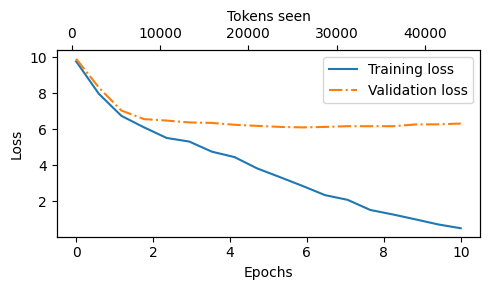

In [28]:
# 导入matplotlib库用于绘图
import matplotlib.pyplot as plt
# 导入MaxNLocator用于设置x轴刻度为整数
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    # 创建一个5x3英寸大小的图形和坐标轴对象
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 在第一个y轴上绘制训练损失曲线
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    # 在同一个y轴上绘制验证损失曲线,使用虚线样式
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    # 设置x轴标签为"Epochs"
    ax1.set_xlabel("Epochs")
    # 设置y轴标签为"Loss" 
    ax1.set_ylabel("Loss")
    # 在右上角添加图例
    ax1.legend(loc="upper right")
    # 设置x轴刻度为整数
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # 创建第二个x轴,共享y轴
    ax2 = ax1.twiny()
    # 绘制一个透明的曲线用于对齐刻度
    ax2.plot(tokens_seen, train_losses, alpha=0)
    # 设置第二个x轴的标签为"Tokens seen"
    ax2.set_xlabel("Tokens seen")

    # 自动调整布局,确保所有元素可见
    fig.tight_layout()
    # 将图形保存为PDF文件
    plt.savefig("loss-plot.pdf")
    # 显示图形
    plt.show()

# 创建一个从0到num_epochs的等间距张量,长度与train_losses相同
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# 调用绘图函数绘制损失曲线
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- 从上面的结果可以看出,模型一开始生成的是无法理解的词串,而到最后,它能够生成语法上或多或少正确的句子

- However, based on the training and validation set losses, we can see that the model starts overfitting
- 然而,根据训练集和验证集的损失,我们可以看到模型开始过拟合

- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
- 如果我们检查它在最后写的一些段落,我们会发现它们完全包含在训练集中 -- 它只是简单地记住了训练数据

- Later, we will cover decoding strategies that can mitigate this memorization by a certain degree
- 稍后,我们将介绍可以在一定程度上缓解这种记忆的解码策略

- Note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
- 注意,这里的过拟合发生是因为我们的训练集非常非常小,而且我们对它进行了多次迭代

  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - 这里的LLM训练主要用于教育目的;我们主要想看到模型能够学会生成连贯的文本
  
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later
  - 我们不会花费数周或数月在大量昂贵的硬件上训练这个模型,而是稍后加载预训练的权重

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

**If you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code)**
**如果您对使用更高级的技术来增强这个训练函数感兴趣，比如学习率预热、余弦退火和梯度裁剪，请参考[附录D](../../appendix-D/01_main-chapter-code)**

**If you are interested in a larger training dataset and longer training run, see [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**
**如果您对更大的训练数据集和更长时间的训练感兴趣，请参阅[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 Decoding strategies to control randomness
## 5.3 控制随机性的解码策略

- Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it in case you used a GPU for training it above
- 对于我们上面训练的GPT这样相对较小的LLM来说,推理的成本相对较低,因此即使您之前使用GPU进行训练,现在也不需要使用GPU

- Using the `generate_text_simple` function (from the previous chapter) that we used earlier inside the simple training function, we can generate new text one word (or token) at a time
- 使用我们之前在简单训练函数中使用的`generate_text_simple`函数(来自上一章),我们可以一次生成一个词(或标记)的新文本

- As explained in section 5.1.2, the next generated token is the token corresponding to the largest probability score among all tokens in the vocabulary
- 正如5.1.2节所解释的,下一个生成的标记是词汇表中所有标记中概率分数最大的标记

In [29]:
# 将模型移到CPU上
model.to("cpu")
# 将模型设置为评估模式
model.eval()

# 获取GPT-2的分词器
tokenizer = tiktoken.get_encoding("gpt2")

# 使用generate_text_simple函数生成文本
token_ids = generate_text_simple(
    # 传入模型
    model=model,
    # 将输入文本转换为token ID序列
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    # 设置最多生成25个新token
    max_new_tokens=25,
    # 设置上下文长度
    context_size=GPT_CONFIG_124M["context_length"]
)

# 打印生成的文本,将token ID转换回文本
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- Even if we execute the `generate_text_simple` function above multiple times, the LLM will always generate the same outputs
- 即使我们多次执行上面的`generate_text_simple`函数,LLM也会始终生成相同的输出
- We now introduce two concepts, so-called decoding strategies, to modify the `generate_text_simple`: *temperature scaling* and *top-k* sampling  
- 现在我们介绍两个概念,即所谓的解码策略,用来修改`generate_text_simple`:*温度缩放*和*top-k*采样
- These will allow the model to control the randomness and diversity of the generated text
- 这些将允许模型控制生成文本的随机性和多样性

### 5.3.1 Temperature scaling
### 5.3.1 温度缩放

 - Previously, we always sampled the token with the highest probability as the next token using `torch.argmax`
- 之前,我们总是使用`torch.argmax`来采样概率最高的标记作为下一个标记
 - To add variety, we can sample the next token using The `torch.multinomial(probs, num_samples=1)`, sampling from a probability distribution  
- 为了增加多样性,我们可以使用`torch.multinomial(probs, num_samples=1)`来从概率分布中采样下一个标记
 - Here, each index's chance of being picked corresponds to its probability in the input tensor
- 在这里,每个索引被选中的概率对应于输入张量中的概率值

- Here's a little recap of generating the next token, assuming a very small vocabulary for illustration purposes:
- 这里简单回顾一下如何生成下一个标记,为了说明目的我们假设一个很小的词汇表:

In [30]:
# 定义一个简单的词汇表,将单词映射到索引
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

# 创建一个反向词汇表,将索引映射回单词
inverse_vocab = {v: k for k, v in vocab.items()}

# 假设输入是"every effort moves you",LLM
# 返回下一个标记的logits值:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

# 对logits应用softmax函数得到概率分布
probas = torch.softmax(next_token_logits, dim=0)
# 使用argmax获取概率最高的标记ID
next_token_id = torch.argmax(probas).item()

# 打印生成的下一个标记
print(inverse_vocab[next_token_id])

forward


In [31]:
# 设置随机种子以确保结果可重现
torch.manual_seed(123)
# 使用multinomial从概率分布中采样一个token
next_token_id = torch.multinomial(probas, num_samples=1).item()
# 打印采样得到的token对应的单词
print(inverse_vocab[next_token_id])

toward


- Instead of determining the most likely token via `torch.argmax`, we use `torch.multinomial(probas, num_samples=1)` to determine the most likely token by sampling from the softmax distribution
- 我们不使用`torch.argmax`来确定最可能的标记,而是使用`torch.multinomial(probas, num_samples=1)`从softmax分布中采样来确定最可能的标记
- For illustration purposes, let's see what happens when we sample the next token 1,000 times using the original softmax probabilities:
- 为了说明目的,让我们看看使用原始softmax概率采样1000次下一个标记会发生什么:

In [32]:
# 定义一个函数来打印采样得到的标记
def print_sampled_tokens(probas):
    # 设置随机种子以确保结果可重现
    torch.manual_seed(123) # Manual seed for reproducibility
    # 从概率分布中采样1000次,每次采样1个标记
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    # 统计每个标记出现的频率
    sampled_ids = torch.bincount(torch.tensor(sample))
    # 遍历每个标记ID及其频率
    for i, freq in enumerate(sampled_ids):
        # 打印标记出现的次数及对应的单词
        print(f"{freq} x {inverse_vocab[i]}")

# 调用函数打印采样结果
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- We can control the distribution and selection process via a concept called temperature scaling
- 我们可以通过一个叫做温度缩放的概念来控制分布和选择过程
- "Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0
- "温度缩放"只是将logits除以一个大于0的数的花哨说法
- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- 温度大于1会导致在应用softmax后得到更均匀分布的标记概率
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax
- 温度小于1会导致在应用softmax后得到更自信(更尖锐或更有峰值)的分布

In [33]:
# 定义一个函数,接收logits和temperature作为参数,实现带温度的softmax计算
def softmax_with_temperature(logits, temperature):
    # 将logits除以temperature进行缩放
    scaled_logits = logits / temperature
    # 对缩放后的logits应用softmax函数,dim=0表示在第0维度上进行softmax
    return torch.softmax(scaled_logits, dim=0)

# 定义不同的温度值:1表示原始分布,0.1表示更自信的分布,5表示更均匀的分布
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# 使用列表推导式,对每个温度值计算对应的概率分布
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

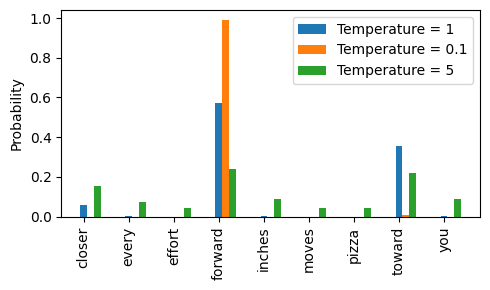

In [34]:
# 绘图部分
# 创建一个包含词汇表长度的序列作为x轴坐标
x = torch.arange(len(vocab))
# 设置柱状图的宽度
bar_width = 0.15

# 创建一个5x3大小的图形和坐标轴对象
fig, ax = plt.subplots(figsize=(5, 3))
# 对每个温度值循环绘制柱状图
for i, T in enumerate(temperatures):
    # 绘制柱状图,x轴位置根据索引i偏移,使用scaled_probas[i]作为高度,设置标签包含温度值
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

# 设置y轴标签为"Probability"
ax.set_ylabel('Probability')
# 设置x轴刻度位置
ax.set_xticks(x)
# 设置x轴刻度标签为词汇表中的单词,90度旋转以防重叠
ax.set_xticklabels(vocab.keys(), rotation=90)
# 添加图例
ax.legend()

# 自动调整布局以防止标签被切割
plt.tight_layout()
# 将图保存为PDF文件
plt.savefig("temperature-plot.pdf")
# 显示图形
plt.show()

- We can see that the rescaling via temperature 0.1 results in a sharper distribution, approaching `torch.argmax`, such that the most likely word is almost always selected:
- 我们可以看到，通过温度0.1进行重新缩放会产生更尖锐的分布，接近`torch.argmax`，这样最可能的词几乎总是被选中：

In [35]:
# 使用温度为0.1的概率分布(scaled_probas[1])打印采样的token
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


- The rescaled probabilities via temperature 5 are more uniformly distributed:
- 通过温度5重新缩放的概率分布更加均匀:

In [36]:
# 使用温度为5的概率分布打印采样的token
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


- Assuming an LLM input "every effort moves you", using the approach above can sometimes result in nonsensical texts, such as "every effort moves you pizza", 3.2% of the time (32 out of 1000 times)
- 假设LLM输入为"every effort moves you"，使用上述方法有时会产生无意义的文本，比如"every effort moves you pizza"，这种情况发生的概率为3.2%(1000次中有32次)

### 5.3.2 Top-k sampling
### 5.3.2 Top-k 采样

- To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens:
- 为了能够使用更高的温度来增加输出的多样性并减少无意义句子的概率，我们可以将采样的token限制在最可能的前k个token中:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- (Please note that the numbers in this figure are truncated to two
digits after the decimal point to reduce visual clutter. The values in the Softmax row should add up to 1.0.)
- (请注意，为了减少视觉混乱，此图中的数字被截断为小数点后两位。Softmax行中的值加起来应该等于1.0。)

- In code, we can implement this as follows:
- 在代码中，我们可以按如下方式实现:

In [37]:
# 设置top-k的值为3
top_k = 3

# 使用torch.topk获取next_token_logits中最大的k个值及其位置
# top_logits存储k个最大值,top_pos存储这些值的位置索引
top_logits, top_pos = torch.topk(next_token_logits, top_k)

# 打印最大的k个logits值
print("Top logits:", top_logits)
# 打印这些logits值对应的位置索引
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [38]:
# 使用torch.where创建新的logits张量
# 条件: 如果next_token_logits中的值小于top_k个最大值中的最小值
# 则将该位置的值设为负无穷
# 否则保持原值不变
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],  # 判断条件:是否小于top-k中的最小值
    input=torch.tensor(float("-inf")),             # 如果条件为真,设为负无穷
    other=next_token_logits                        # 如果条件为假,保持原值
)

# 打印处理后的logits张量
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> NOTE:  
> 注意：
>
>  An alternative, slightly more efficient implementation of the previous code cell is the following:
>  以下是前一个代码单元的另一种稍微更高效的实现方式：
>
> ```python
> new_logits = torch.full_like( # create tensor containing -inf values
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
> ```
> <br>
> For more details, see https://github.com/rasbt/LLMs-from-scratch/discussions/326
> 更多详情请参见 https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [39]:
# 对经过top-k过滤后的logits张量应用softmax函数,得到概率分布
topk_probas = torch.softmax(new_logits, dim=0)
# 打印top-k采样后的概率分布
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function
### 5.3.3 修改文本生成函数

- The previous two subsections introduced temperature sampling and top-k sampling
- 前面两个小节介绍了温度采样和top-k采样
- Let's use these two concepts to modify the `generate_simple` function we used to generate text via the LLM earlier, creating a new `generate` function:
- 让我们使用这两个概念来修改之前用于通过LLM生成文本的`generate_simple`函数，创建一个新的`generate`函数：

In [40]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    文本生成函数
    参数:
        model: GPT模型
        idx: 输入token序列
        max_new_tokens: 最大生成token数量
        context_size: 上下文窗口大小
        temperature: 温度参数,控制采样随机性
        top_k: top-k采样的k值
        eos_id: 结束符token的id
    """
    # 循环生成指定数量的新token
    for _ in range(max_new_tokens):
        # 截取最后context_size个token作为条件输入
        idx_cond = idx[:, -context_size:]
        
        # 使用no_grad上下文管理器,不计算梯度
        with torch.no_grad():
            # 通过模型获取logits输出
            logits = model(idx_cond)
        
        # 只保留最后一个时间步的logits
        logits = logits[:, -1, :]

        # 如果指定了top_k,进行top-k采样过滤
        if top_k is not None:
            # 获取logits中最大的top_k个值
            top_logits, _ = torch.topk(logits, top_k)
            # 获取第k大的值作为阈值
            min_val = top_logits[:, -1]
            # 将小于阈值的logits设置为负无穷
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 如果temperature大于0,进行温度采样
        if temperature > 0.0:
            # 对logits进行温度缩放
            logits = logits / temperature

            # 使用softmax将logits转换为概率分布
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从概率分布中采样下一个token
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 如果temperature为0,直接选择概率最大的token
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        # 如果生成了结束符token且指定了eos_id,提前结束生成
        if idx_next == eos_id:
            break

        # 将新生成的token拼接到序列末尾
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [41]:
# 设置随机种子为123,保证结果可复现
torch.manual_seed(123)

# 使用generate函数生成文本
token_ids = generate(
    # 传入训练好的模型
    model=model,
    # 将输入文本转换为token id序列作为初始条件
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    # 最多生成15个新token
    max_new_tokens=15,
    # 设置上下文窗口大小为模型配置中的context_length
    context_size=GPT_CONFIG_124M["context_length"],
    # 使用top-k采样,只保留概率最大的前25个token
    top_k=25,
    # 设置采样温度为1.4,增加采样的随机性
    temperature=1.4
)

# 将生成的token id序列转换回文本并打印输出
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


## 5.4 Loading and saving model weights in PyTorch
## 5.4 在PyTorch中加载和保存模型权重

- Training LLMs is computationally expensive, so it's crucial to be able to save and load LLM weights
- 训练大语言模型需要大量计算资源，因此能够保存和加载模型权重至关重要

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width=400px>

- The recommended way in PyTorch is to save the model weights, the so-called `state_dict` via by applying the `torch.save` function to the `.state_dict()` method:
- 在PyTorch中推荐的方法是通过对`.state_dict()`方法应用`torch.save`函数来保存模型权重，即所谓的`state_dict`：

In [42]:
# 使用torch.save()函数保存模型的状态字典(state_dict)
# model.state_dict()包含了模型的所有参数(权重和偏置)
# 将其保存到名为"model.pth"的文件中
torch.save(model.state_dict(), "model.pth")

- Then we can load the model weights into a new `GPTModel` model instance as follows:
- 然后我们可以按照如下方式将模型权重加载到新的`GPTModel`模型实例中：

In [43]:
# 创建一个新的GPT模型实例,使用124M参数配置
model = GPTModel(GPT_CONFIG_124M)
# 检查是否有可用的GPU,如果有则使用GPU,否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 从保存的文件中加载模型权重,并将其映射到指定设备上,只加载权重数据
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
# 将模型设置为评估模式
model.eval();

- It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
- 通常使用Adam或AdamW这样的自适应优化器来训练大语言模型,而不是普通的SGD
- These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later:
- 这些自适应优化器为每个模型权重存储额外的参数,因此如果我们计划稍后继续预训练,保存这些参数也是有意义的:

In [44]:
# 使用torch.save()保存模型和优化器的状态字典
# 创建一个字典来存储两个状态字典:
# - model_state_dict: 包含模型的权重和偏置参数
# - optimizer_state_dict: 包含优化器的状态参数
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [45]:
# 从保存的文件中加载模型和优化器的状态字典
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

# 创建一个新的GPT模型实例
model = GPTModel(GPT_CONFIG_124M)
# 加载模型的状态字典(权重和偏置参数)
model.load_state_dict(checkpoint["model_state_dict"])

# 创建一个新的AdamW优化器实例,设置学习率和权重衰减
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
# 加载优化器的状态字典(优化器参数)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# 将模型设置为训练模式
model.train();

## 5.5 Loading pretrained weights from OpenAI
## 5.5 从OpenAI加载预训练权重

- Previously, we only trained a small GPT-2 model using a very small short-story book for educational purposes
- 之前,我们仅使用一本很小的短篇故事书训练了一个小型GPT-2模型用于教学目的

- Interested readers can also find a longer pretraining run on the complete Project Gutenberg book corpus in [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)
- 感兴趣的读者可以在[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)中找到在完整的古腾堡计划图书语料库上进行的更长时间的预训练运行

- Fortunately, we don't have to spend tens to hundreds of thousands of dollars to pretrain the model on a large pretraining corpus but can load the pretrained weights provided by OpenAI
- 幸运的是,我们不必花费数十万到数十万美元在大型预训练语料库上预训练模型,而是可以加载OpenAI提供的预训练权重

- For an alternative way to load the weights from the Hugging Face Hub, see [../02_alternative_weight_loading](../02_alternative_weight_loading)

- First, some boilerplate code to download the files from OpenAI and load the weights into Python
- Since OpenAI used [TensorFlow](https://www.tensorflow.org/), we will have to install and use TensorFlow for loading the weights; [tqdm](https://github.com/tqdm/tqdm) is a progress bar library
- Uncomment and run the next cell to install the required libraries

In [46]:
# pip install tensorflow tqdm

In [47]:
# 打印TensorFlow和tqdm的版本信息
print("TensorFlow version:", version("tensorflow"))  # 打印TensorFlow版本
print("tqdm version:", version("tqdm"))  # 打印tqdm版本

TensorFlow version: 2.18.0
tqdm version: 4.66.5


In [48]:
# 从当前文件夹中的gpt_download.py相对导入
from gpt_download import download_and_load_gpt2

- We can then download the model weights for the 124 million parameter model as follows:
- 然后我们可以按如下方式下载124百万参数模型的权重:

In [49]:
# 下载并加载124M参数的GPT-2模型权重
# settings包含模型配置信息,params包含模型参数
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 78.0kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 607kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 43.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [19:36<00:00, 423kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.21MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:02<00:00, 173kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:02<00:00, 160kiB/s]  


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd1 in position 9: invalid continuation byte

In [50]:
# 打印模型配置信息
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [51]:
# 打印参数字典的键
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [52]:
# 打印词元嵌入权重矩阵
print(params["wte"])
# 打印词元嵌入权重张量的维度
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- Alternatively, "355M", "774M", and "1558M" are also supported `model_size` arguments
- 另外,"355M"、"774M"和"1558M"也是支持的`model_size`参数
- The difference between these differently sized models is summarized in the figure below:
- 这些不同大小模型之间的差异总结在下图中:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our `GPTModel` instance
- 上面我们将124M GPT-2模型权重加载到Python中,但我们仍需要将它们传输到我们的`GPTModel`实例中

- First, we initialize a new GPTModel instance  
- 首先,我们初始化一个新的GPTModel实例

- Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting `qkv_bias` to `True` in our implementation, too
- 注意,原始GPT模型在多头注意力模块中使用偏置向量初始化查询、键和值矩阵的线性层,这不是必需的也不推荐;但是,为了能够正确加载权重,我们也必须通过在实现中将`qkv_bias`设置为`True`来启用这些

- We are also using the `1024` token context length that was used by the original GPT-2 model(s)
- 我们还使用了原始GPT-2模型使用的`1024`词元上下文长度

In [53]:
# Define model configurations in a dictionary for compactness
# 定义不同GPT-2模型配置的字典,包含嵌入维度、层数和注意力头数
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},  # 小型124M参数模型
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},  # 中型355M参数模型 
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},  # 大型774M参数模型
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},  # 超大型1558M参数模型
}

# 复制基础配置并使用特定模型设置更新
model_name = "gpt2-small (124M)"  # 选择使用124M小型模型
NEW_CONFIG = GPT_CONFIG_124M.copy()  # 复制基础配置
NEW_CONFIG.update(model_configs[model_name])  # 更新模型特定参数
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})  # 设置上下文长度和QKV偏置

# 初始化GPT模型并设置为评估模式
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- The next task is to assign the OpenAI weights to the corresponding weight tensors in our `GPTModel` instance
- 下一个任务是将OpenAI的权重分配给我们的`GPTModel`实例中对应的权重张量

In [54]:
def assign(left, right):
    # 检查左右张量形状是否匹配
    if left.shape != right.shape:
        # 如果形状不匹配,抛出ValueError异常
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    # 将右侧张量转换为PyTorch参数并返回
    return torch.nn.Parameter(torch.tensor(right))

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    # 加载位置嵌入权重
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    # 加载词元嵌入权重
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    # 遍历每个Transformer块
    for b in range(len(params["blocks"])):
        # 将注意力权重矩阵分割为查询、键、值三部分
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        # 加载查询权重矩阵(需要转置)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        # 加载键权重矩阵(需要转置)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        # 加载值权重矩阵(需要转置)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # 将注意力偏置向量分割为查询、键、值三部分
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        # 加载查询偏置向量
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        # 加载键偏置向量
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        # 加载值偏置向量
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        # 加载注意力输出投影层的权重(需要转置)
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        # 加载注意力输出投影层的偏置
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # 加载前馈网络第一层的权重(需要转置)
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        # 加载前馈网络第一层的偏置
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        # 加载前馈网络第三层(输出层)的权重(需要转置)
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        # 加载前馈网络第三层(输出层)的偏置
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # 加载第一个层归一化的缩放参数
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        # 加载第一个层归一化的偏移参数
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        # 加载第二个层归一化的缩放参数
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        # 加载第二个层归一化的偏移参数
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    # 加载最终层归一化的缩放参数
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    # 加载最终层归一化的偏移参数
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    # 加载输出头的权重(与词元嵌入共享权重)
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
# 加载权重并将模型移至指定设备    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- If the model is loaded correctly, we can use it to generate new text using our previous `generate` function:
- 如果模型加载正确,我们可以使用之前的`generate`函数来生成新的文本:

In [56]:
# 设置随机种子以确保结果可重现
torch.manual_seed(123)

# 使用GPT模型生成文本
token_ids = generate(
    # 传入GPT模型实例
    model=gpt,
    # 将输入提示文本转换为token ID并移至指定设备
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    # 设置要生成的新token数量为25个
    max_new_tokens=25,
    # 设置上下文窗口大小,使用配置文件中定义的长度
    context_size=NEW_CONFIG["context_length"],
    # 设置top_k采样参数为50,即只从概率最高的50个token中采样
    top_k=50,
    # 设置temperature(温度)参数为1.5,较高的温度会增加采样的随机性
    temperature=1.5
)

# 将生成的token ID序列转换回可读文本并打印输出
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- We know that we loaded the model weights correctly because the model can generate coherent text; if we made even a small mistake, the model would not be able to do that
- 我们知道模型权重加载正确,因为模型能够生成连贯的文本;如果我们犯了哪怕一个小错误,模型都无法做到这一点

- For an alternative way to load the weights from the Hugging Face Hub, see [../02_alternative_weight_loading](../02_alternative_weight_loading)
- 关于从Hugging Face Hub加载权重的另一种方式,请参见[../02_alternative_weight_loading](../02_alternative_weight_loading)
- If you are interested in seeing how the GPT architecture compares to the Llama architecture (a popular LLM developed by Meta AI), see the bonus content at [../07_gpt_to_llama](../07_gpt_to_llama)
- 如果你想了解GPT架构与Llama架构(Meta AI开发的一个流行的大语言模型)的比较,请查看[../07_gpt_to_llama](../07_gpt_to_llama)的额外内容

## Summary and takeaways
## 总结和要点

- See the [./gpt_train.py](./gpt_train.py) script, a self-contained script for training
- The [./gpt_generate.py](./gpt_generate.py) script loads pretrained weights from OpenAI and generates text based on a prompt
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)